In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Configurações Iniciais

### Importações e carregamento dos dados

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import joblib
import matplotlib.pyplot as plt # Gráficos
import seaborn as sns # Gráficos
from tqdm.notebook import tqdm # Barras de Progresso

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from keras.models import Sequential, load_model

from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [ ]:
X = pd.read_csv("/content/drive/My Drive/UFPE/UFPE 2024.1/PET/Imersão/Network Databases/attacks.csv")

### Rotulação, Timestemp, Bools, Int

In [ ]:
# Rotular os dados ## 0 - BENIGN | 1 - MALICIOUS

X['Attack Name'] = "-"
X['Attack Name'] = X['B1'].apply(lambda x:
                                           "Spoofing" if x == 1
                                           else "Fuzzy" if x == 2
                                           else "Replay" if x == 4
                                           else "DDoS" if x ==3
                                           else "-")

X['Label'] = X['B1'].apply(lambda x: 1.0 if x in [1, 2, 3, 4] else 0.0)

In [ ]:
# Tratando os valores do timestamp

X['Timestamp'] = pd.to_datetime(X['Timestamp'], unit='s')
X['Timestamp'] = (X['Timestamp'] - X['Timestamp'].min()).dt.total_seconds()

In [ ]:
# Trocando o valor de False para 0.0

X['RTR'] = X['Extended ID'] = X['B1'] = 0.0

In [ ]:
# Passar os valores inteiros para o tipo float

columns = ['Arbitration ID', 'DLC', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']

for column in columns:
  X[column] = X[column].apply(lambda x: float(x))

### Conjunto de teste e validação e Labels

In [ ]:
validation_size = int(len(X)*.65)

X_val, X_test = X[:validation_size], X[validation_size:]

y_val = X_val['Label']
X_val = X_val.drop('Label', axis=1).drop('Attack Name', axis=1)

y_test = X_test['Label']
X_test = X_test.drop('Label', axis=1).drop('Attack Name', axis=1)

### Funções para avaliação

In [ ]:
# Função para desenhar a matriz de confusão

def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

In [ ]:
# Função para plotar a curva ROC

def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)

  ## Configurações do gráfico
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
# Função para calcular a taxa de vedadeiros positivos por ataque

def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})

  total_per_label = aux_df['Label'].value_counts().to_dict()

  correct_predictions_per_label = aux_df.query('Label != 0 and prediction == True').groupby('Label').size().to_dict()

  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 0: # Pula se for benigno
      continue

    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr

  return tpr_per_attack

In [ ]:
# Função para calcular métricas gerais

def get_overall_metrics(y_true, y_pred):
  ## tn (verdadeiros negativos), fp (falsos positivos), fn (falsos negativos), tp (verdadeiros positivos)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  acc = (tp+tn)/(tp+tn+fp+fn) ## Cálculo da acurácia (proporção de amostras classificadas corretamente)

  tpr = tp/(tp+fn) ## Cálculo da taxa de verdadeiros positivos
  fpr = fp/(fp+tn) ## Cálculo da taxa de falsos positivos

  precision = tp/(tp+fp) ## Cálculo da precisão (proporção dos verdadeiros positivos dentre todos os positivos obtidos)
  f1 = (2*tpr*precision)/(tpr+precision) ## Cálculo do f1-score (média harmonica entre a precisão e o recall)

  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

## Avaliação Autoencoder LSTM

In [ ]:
# Carregamento do modelo e do normalizador

loaded_model_lstm = load_model('lstmDrop.keras')
loaded_scaler_lstm = joblib.load('scalerDrop.pkl')

### Preparação dos dados

In [ ]:
def create_sequences(data, steps):
  sequences = []
  for i in range(len(data) - steps):
    sequences.append(data[i:i+steps])

  return np.array(sequences)

In [ ]:
# Normalizar os dados

X_val_lstm = loaded_scaler_lstm.transform(X_val)

In [ ]:
# Gerando as sequências

timesteps = 3 #4

X_val_lstm = create_sequences(X_val_lstm, timesteps)

### Validação

In [ ]:
# Gerando reconstruções

reconstructions = loaded_model_lstm.predict(X_val_lstm)
mse = np.mean(np.power(X_val_lstm - reconstructions, 2), axis=(1, 2))

16587/16587 [==============================] - 116s 7ms/step


In [ ]:
threshold = np.percentile(mse, 73.9) # 83  # 66.073
anomalies = mse > threshold

print(f"Anomalias detectadas: {np.sum(anomalies)}")
print(f"Anomlias existentes:  {(X['Label'] == 1.0).sum()}")

Anomalias detectadas: 138528
Anomlias existentes:  138954


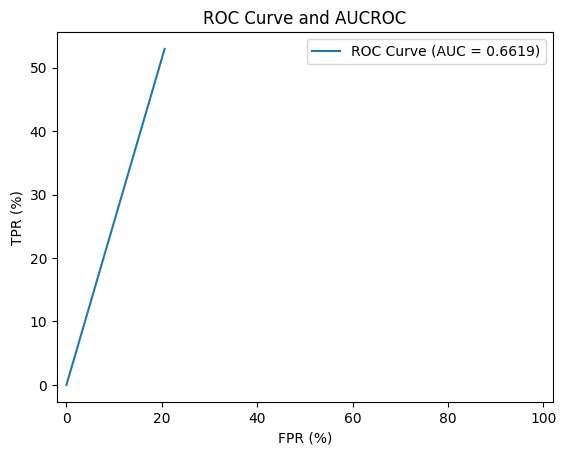

In [ ]:
plot_roc_curve(y_val[:-3], anomalies, max_fpr=1.0)

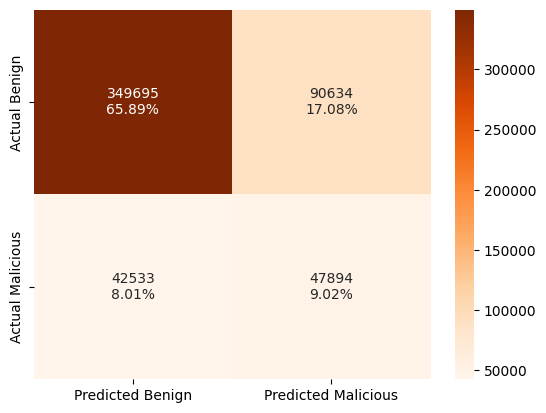

In [ ]:
plot_confusion_matrix(y_val[:-3], anomalies)

In [ ]:
get_overall_metrics(y_val[:-3], anomalies)

{'acc': 0.7490993978400621,
 'tpr': 0.529642695212713,
 'fpr': 0.20583245709458156,
 'precision': 0.3457351582351582,
 'f1-score': 0.4183704221353541}

## Avaliação KMeans

In [ ]:
RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)

In [ ]:
# Carregamento do modelo e do normalizador

from pickle import load
import joblib

with open("kmeans.pkl", "rb") as f:
    loaded_model_kmeans = load(f)

loaded_scaler_kmeans = joblib.load('scalerKMeans.pkl')

In [ ]:
#
X_val_kmeans = loaded_scaler_kmeans.transform(X_val)
y_val_kmeans = y_val

X_test_kmeans = loaded_scaler_kmeans.transform(X_test)
y_test_kmeans = y_test

### Validação

In [ ]:
val_centroids_distances = loaded_model_kmeans.transform(X_val_kmeans)
val_anomaly_scores = np.min(val_centroids_distances, axis=1)

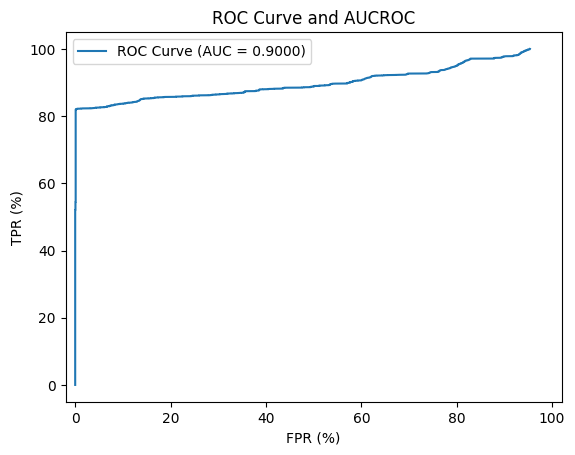

In [ ]:
plot_roc_curve(y_val_kmeans, val_anomaly_scores)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val_kmeans, val_anomaly_scores)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})

df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

,fpr,tpr,thresholds,youden-index
1312,0.001011,0.819691,2.239955,0.818680
1324,0.002098,0.820775,2.099740,0.818676
1322,0.002094,0.820697,2.104287,0.818603
1320,0.002087,0.820542,2.107644,0.818455
1318,0.002078,0.820465,2.114111,0.818387
...,...,...,...,...
21478,0.952692,0.998562,0.197386,0.045870
21476,0.952690,0.998551,0.197389,0.045861
21474,0.952688,0.998540,0.197393,0.045852
21472,0.952686,0.998529,0.197397,0.045844


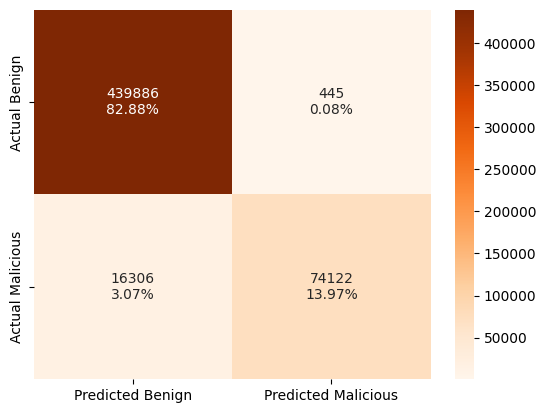

In [ ]:
BEST_VALIDATION_THRESHOLD =  2.239955
plot_confusion_matrix(y_val_kmeans, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val_kmeans, val_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': 0.9684395365881691,
 'tpr': 0.8196797452116601,
 'fpr': 0.0010106033869975088,
 'precision': 0.9940322126409806,
 'f1-score': 0.8984757113851934}

### Teste

In [ ]:
test_centroids_distances = loaded_model_kmeans.transform(X_test_kmeans)
test_anomaly_scores = np.min(test_centroids_distances, axis=1)

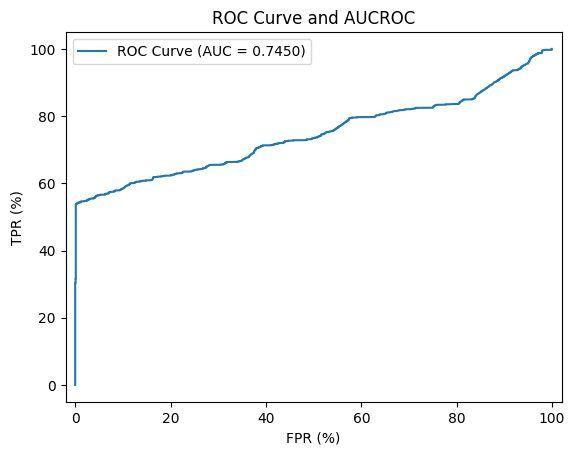

In [ ]:
plot_roc_curve(y_test_kmeans, test_anomaly_scores)

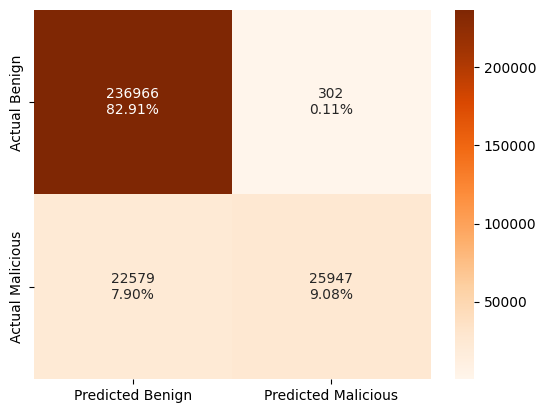

In [ ]:
plot_confusion_matrix(y_test_kmeans, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_test_kmeans, test_anomaly_scores > BEST_VALIDATION_THRESHOLD)

{'acc': 0.919938837064459,
 'tpr': 0.5347030457898858,
 'fpr': 0.0012728222937775006,
 'precision': 0.9884947998018973,
 'f1-score': 0.6940020060180543}

## Avaliação Isolation Forest

In [ ]:
# Carregamento do modelo e do normalizador

from pickle import load
import joblib

with open("IF.pkl", "rb") as f:
    loaded_model_if = load(f)

loaded_scaler_if = joblib.load('scalerIF.pkl')

In [ ]:
#
X_val_if = loaded_scaler_if.transform(X_val)
y_val_if = y_val

X_test_if = loaded_scaler_if.transform(X_test)
y_test_if = y_test

### Validação

In [ ]:
val_scores_iforest = loaded_model_if.score_samples(X_val_if)
val_scores_iforest = np.abs(val_scores_iforest)

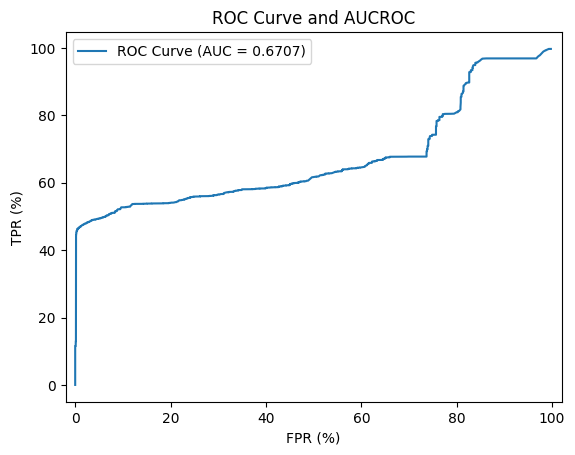

In [ ]:
plot_roc_curve(y_val_if, val_scores_iforest)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val_if, val_scores_iforest)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr')

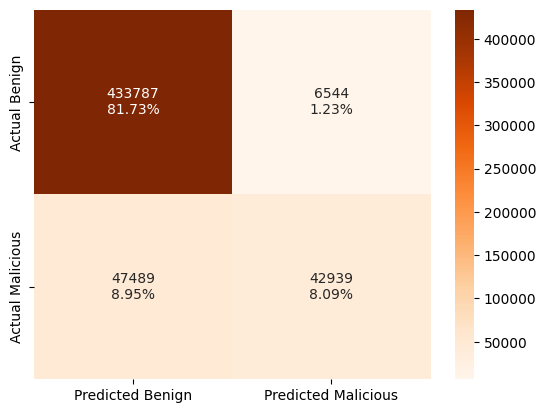

In [ ]:
BEST_IFOREST_VALIDATION_THRESHOLD = 0.631429
plot_confusion_matrix(y_val_if, val_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val_if, val_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

{'acc': 0.8981967333573241,
 'tpr': 0.4748418631397355,
 'fpr': 0.014861547335981341,
 'precision': 0.8677525614857627,
 'f1-score': 0.6138044899972125}

### Teste

In [ ]:
test_scores_iforest = loaded_model_if.score_samples(X_test_if)
test_scores_iforest = np.abs(test_scores_iforest)

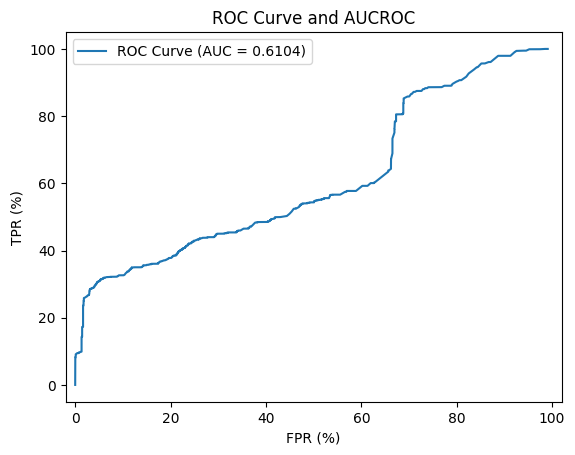

In [ ]:
plot_roc_curve(y_test_if, test_scores_iforest)

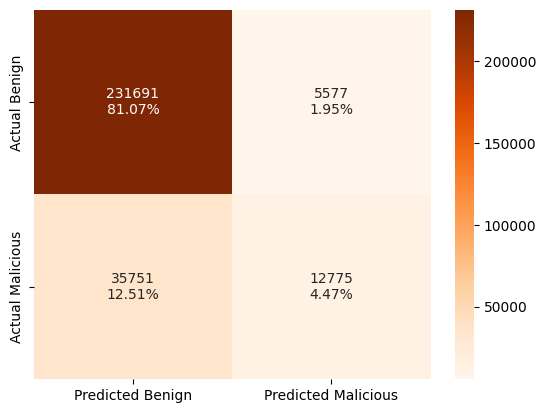

In [ ]:
plot_confusion_matrix(y_test_if, test_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_test_if, test_scores_iforest > BEST_IFOREST_VALIDATION_THRESHOLD)

{'acc': 0.8553923455355956,
 'tpr': 0.2632609322837242,
 'fpr': 0.023505066001314967,
 'precision': 0.6961094158674804,
 'f1-score': 0.3820389365710698}